### Feature Engineering - Application Data

Our previous attempts at feature selection actually lead to a lower score.  This attempt looks at correlations between features, and attempts to apply some simple domain knowledge to create better features.

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import visuals as vs

from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelBinarizer

# Show all of the data in a dataframe
pd.set_option('display.max_columns', None)

In [142]:
# Training Set
application_train = pd.read_csv('data/tmp/application_train_preprocessed_outliers_removed_abs_no_log.csv', index_col = 0)
print("Loaded Training Set: {0} rows".format(application_train.shape[0]))

application_test = pd.read_csv('data/tmp/application_test_preprocessed_outliers_removed_abs_no_log.csv', index_col = 0)
print("Loaded Training Set: {0} rows".format(application_test.shape[0]))

display(application_train.head())

Loaded Training Set: 307511 rows
Loaded Training Set: 48744 rows


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,BOOL_FLAG_EMAIL,BOOL_FLAG_EMP_PHONE,BOOL_FLAG_OWN_CAR,BOOL_FLAG_OWN_REALTY,BOOL_FLAG_PHONE,BOOL_FLAG_WORK_PHONE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_MOBIL,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUR_APPR_PROCESS_START_0,HOUR_APPR_PROCESS_START_1,HOUR_APPR_PROCESS_START_10,HOUR_APPR_PROCESS_START_11,HOUR_APPR_PROCESS_START_12,HOUR_APPR_PROCESS_START_13,HOUR_APPR_PROCESS_START_14,HOUR_APPR_PROCESS_START_15,HOUR_APPR_PROCESS_START_16,HOUR_APPR_PROCESS_START_17,HOUR_APPR_PROCESS_START_18,HOUR_APPR_PROCESS_START_19,HOUR_APPR_PROCESS_START_2,HOUR_APPR_PROCESS_START_20,HOUR_APPR_PROCESS_START_21,HOUR_APPR_PROCESS_START_22,HOUR_APPR_PROCESS_START_23,HOUR_APPR_PROCESS_START_3,HOUR_APPR_PROCESS_START_4,HOUR_APPR_PROCESS_START_5,HOUR_APPR_PROCESS_START_6,HOUR_APPR_PROCESS_START_7,HOUR_APPR_PROCESS_START_8,HOUR_APPR_PROCESS_START_9,HOUSETYPE_MODE_not specified,HOUSETYPE_MODE_org spec account,HOUSETYPE_MODE_reg oper account,HOUSETYPE_MODE_reg oper spec account,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUP

In [38]:
# Features identified as important by AdaBoost 
important_features = pd.read_csv('data/tmp/bureau_important_fields.csv', index_col = 0)
display(important_features.head())

,features
0,EXT_SOURCE_3
1,EXT_SOURCE_2
2,EXT_SOURCE_1
3,AMT_CREDIT
4,AMT_GOODS_PRICE


#### Correlations

In [48]:
correlations = application_train.corr()['TARGET'].sort_values()

In [49]:
print("Top 10 Positive Correlations\n{0}\n".format(correlations.head(n=20)))
print("Top 10 Negative Correlations\n{0}\n".format(correlations.tail(n=20)))

Top 10 Positive Correlations
EXT_SOURCE_2                           -0.159030
EXT_SOURCE_3                           -0.119572
DAYS_BIRTH                             -0.078239
EXT_SOURCE_1                           -0.064698
DAYS_EMPLOYED                          -0.062149
NAME_EDUCATION_TYPE_Higher education   -0.056593
DAYS_LAST_PHONE_CHANGE                 -0.055217
CODE_GENDER_F                          -0.054704
DAYS_ID_PUBLISH                        -0.051457
FLOORSMAX_AVG                          -0.049839
FLOORSMAX_MEDI                         -0.049720
FLOORSMAX_MODE                         -0.049458
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
EMERGENCYSTATE_MODE_No                 -0.042201
DAYS_REGISTRATION                      -0.041975
TOTALAREA_MODE                         -0.041037
YEARS_BEGINEXPLUATATION_MEDI           -0.040983
YEARS_BEGINEXPLUATATION_AVG            -0.040965
YEARS_BEGINEXPLUATATION_MODE           -

In [101]:
# Grab the feature names of the 10 most and least correlated features
hc_features = correlations.index
highly_correlated = list(hc_features[:10])
highly_correlated.extend(list(hc_features[-10:]))

df_hc = application_train[highly_correlated]

In [90]:
hc_corr = df_hc.corr()

#### Correlation Heatmap

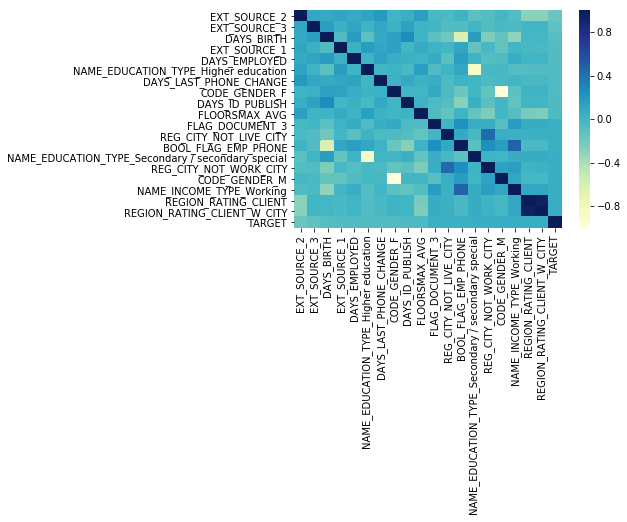

In [91]:
ax = sns.heatmap(hc_corr, cmap="YlGnBu")

#### Observations 

Strong negative correlations between the following  
    - Higher Education vs. Secondary/Special  (Better Education = Better Job)
    - Female vs Male (Women are more responsible)
    - Age and EMPLOYER_PHONE (Product of Age and Employment Status)
    
Strong positive correlations between: 
    - REG_CITY_NOT_WORK_CITY vs REG_CITY_NOT_LIVE_CITY (Long commute to job = more likely to quit/have problems)
    - Income Type: Working vs Flag Emp Phone (Working and provided evidence to prove it == more confidence)
    - Flag Emp Phone vs Flag Doc 3 (Employed and provided some proprietary documentation == more confidence)
    - Days ID Publish vs Age (Age and Established Identity == more confidence that this isn't a fraudulent identity)

#### Correlation Scatter Matrix

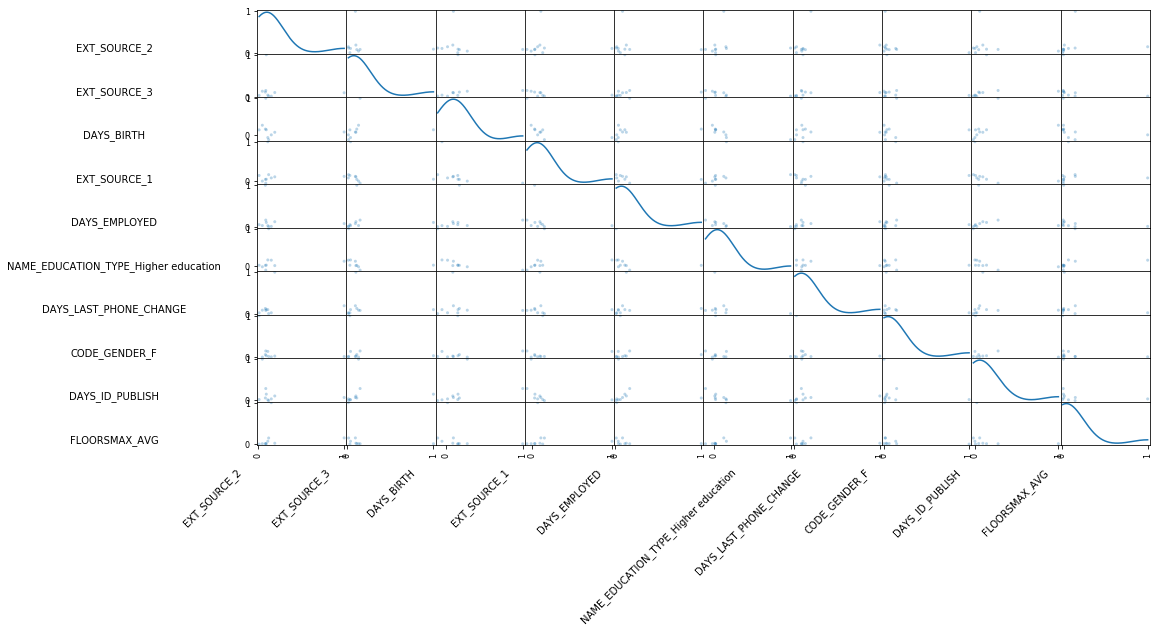

In [29]:
df_hc_top_10 = application_train[highly_correlated[:10]]
df_hc_top_10_corr = df_hc_top_10.corr()

# From customer segments project
from pandas.plotting import scatter_matrix
sm = scatter_matrix(df_hc_top_10_corr, alpha = 0.3, figsize = (16,8), diagonal = 'kde');

#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-1.6,0) for s in sm.reshape(-1)]
[s.get_xaxis().set_label_coords(-.5,-.5) for s in sm.reshape(-1)]

plt.show()

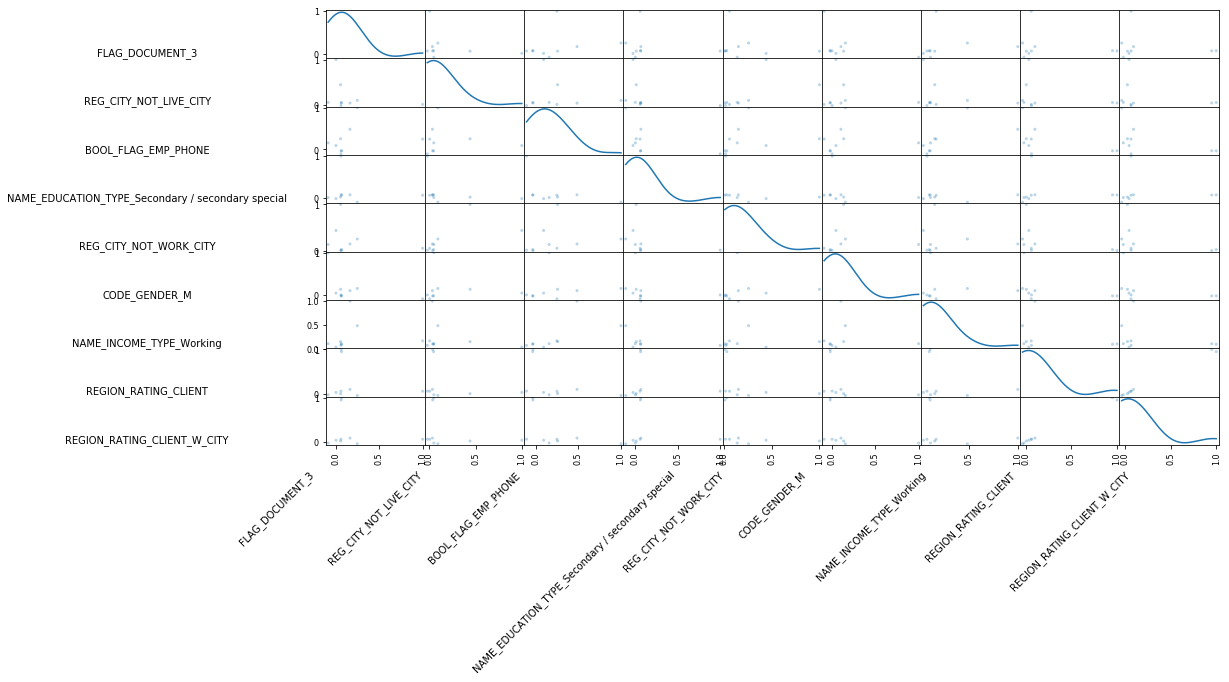

In [33]:
df_hc_bot_10 = application_train[highly_correlated[10:]]
df_hc_bot_10_corr = df_hc_bot_10.corr()

# From customer segments project
from pandas.plotting import scatter_matrix
sm = scatter_matrix(df_hc_bot_10_corr, alpha = 0.3, figsize = (16,8), diagonal = 'kde');

#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-1.8,0) for s in sm.reshape(-1)]
[s.get_xaxis().set_label_coords(-.5,-.5) for s in sm.reshape(-1)]

plt.show()

#### Observations

The following have an interesting impact on distributions: 
- DAYS_LAST_PHONE_CHANGE
- Higher Education
- Age
- BOOL_FLAG_EMP_PHONE
- REG_CITY_NOT_WORK_CITY
- FLAG_DOCUMENT_3

### Revisiting Primary Component Analysis

Considering both our highly correlated and important faatures, I wonder if we can come up with more interesting PCA results

In [143]:
application_train_reduced = application_train[important_features['features'][:10]]
target_train = application_train['TARGET']
display(target_train.head())

0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

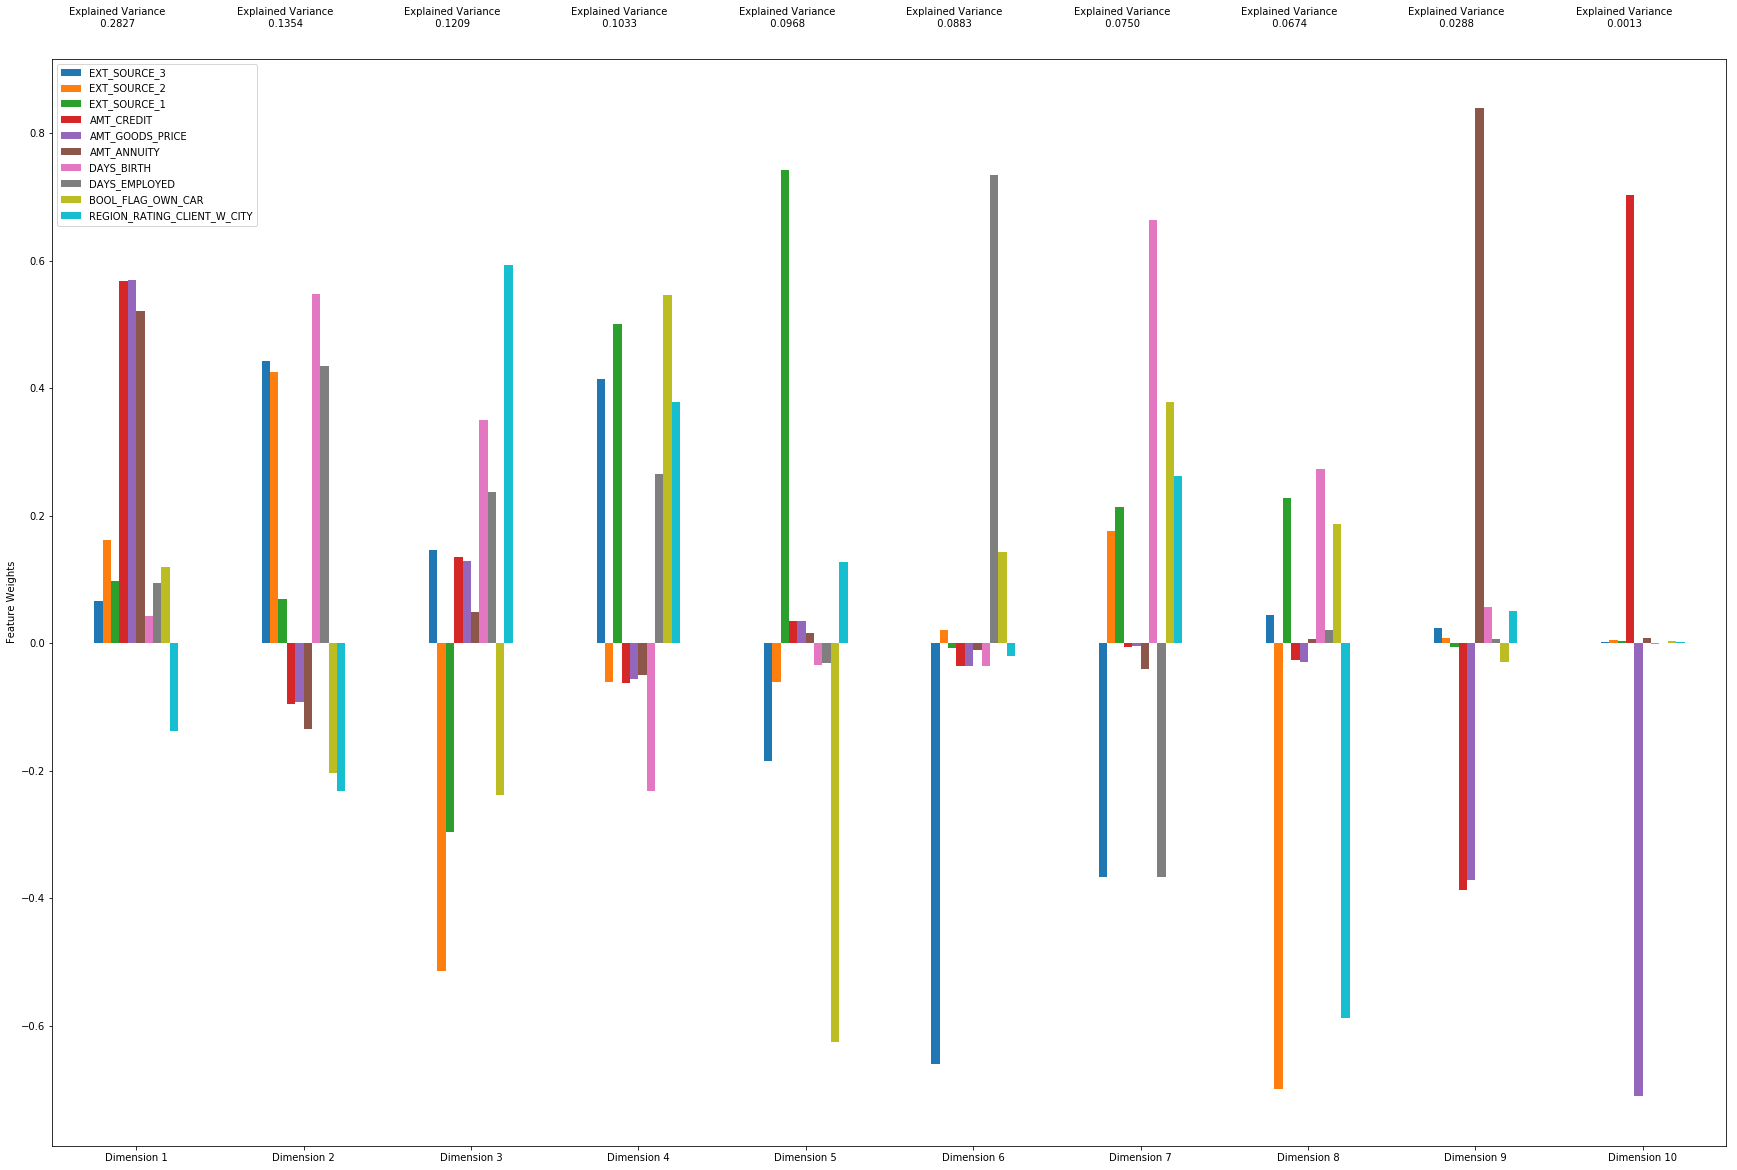

In [123]:
from sklearn.decomposition import PCA

good_data = application_train_reduced

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=10)
pca.fit(application_train_reduced)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(application_train_reduced)

def pca_results(pca_samples, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (30,20))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

# Generate PCA results plot
pca_results = pca_results(pca_samples, pca)

#### Dimension 1

This dimension explains 28.27% of the variance, and is dominated by AMT_CREDIT (the amount of the loan), AMT_GOODS_PRICE (for commercial loans, the amount of the item purchased) and AMT_ANNUITY (the annual payment).  

It would be interesting to see if I can synthesize better features, like ANNUITY and CREDIT as a percentage of INCOME)

In [158]:
df_new_features = application_train
df_new_features = df_new_features.drop('TARGET', axis=1)
df_new_features_SK_ID_CURR = df_new_features['SK_ID_CURR']
df_new_features = df_new_features.drop('SK_ID_CURR', axis=1)

# We need these values to be positive when calculating percentages.... 
df_temp = pd.DataFrame()
df_temp['AMT_CREDIT_OFFSET'] = df_new_features['AMT_CREDIT'] + np.min(df_new_features['AMT_CREDIT'])
df_temp['AMT_INCOME_TOTAL_OFFSET'] = df_new_features['AMT_INCOME_TOTAL'] + np.min(df_new_features['AMT_INCOME_TOTAL'])
df_temp['AMT_GOODS_PRICE_OFFSET'] = df_new_features['AMT_GOODS_PRICE'] + np.min(df_new_features['AMT_GOODS_PRICE'])
df_temp['AMT_ANNUITY_OFFSET'] = df_new_features['AMT_ANNUITY'] + np.min(df_new_features['AMT_ANNUITY'])

# Loan amount as percentage of total income
df_new_features['PER_CREDIT_INCOME'] = df_temp['AMT_CREDIT_OFFSET'] / df_temp['AMT_INCOME_TOTAL_OFFSET']

# Cost of Goods as a percentage of the loan (I suspect this will be 1 all the time)
df_new_features['PER_GOODS_CREDIT'] = df_temp['AMT_GOODS_PRICE_OFFSET'] / df_temp['AMT_CREDIT_OFFSET']

# Loan payment as a percentage of total income
df_new_features['PER_ANNUITY_INCOME'] = df_temp['AMT_ANNUITY_OFFSET'] / df_temp['AMT_INCOME_TOTAL_OFFSET']

display(df_new_features.head())

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,BOOL_FLAG_EMAIL,BOOL_FLAG_EMP_PHONE,BOOL_FLAG_OWN_CAR,BOOL_FLAG_OWN_REALTY,BOOL_FLAG_PHONE,BOOL_FLAG_WORK_PHONE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_MOBIL,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUR_APPR_PROCESS_START_0,HOUR_APPR_PROCESS_START_1,HOUR_APPR_PROCESS_START_10,HOUR_APPR_PROCESS_START_11,HOUR_APPR_PROCESS_START_12,HOUR_APPR_PROCESS_START_13,HOUR_APPR_PROCESS_START_14,HOUR_APPR_PROCESS_START_15,HOUR_APPR_PROCESS_START_16,HOUR_APPR_PROCESS_START_17,HOUR_APPR_PROCESS_START_18,HOUR_APPR_PROCESS_START_19,HOUR_APPR_PROCESS_START_2,HOUR_APPR_PROCESS_START_20,HOUR_APPR_PROCESS_START_21,HOUR_APPR_PROCESS_START_22,HOUR_APPR_PROCESS_START_23,HOUR_APPR_PROCESS_START_3,HOUR_APPR_PROCESS_START_4,HOUR_APPR_PROCESS_START_5,HOUR_APPR_PROCESS_START_6,HOUR_APPR_PROCESS_START_7,HOUR_APPR_PROCESS_START_8,HOUR_APPR_PROCESS_START_9,HOUSETYPE_MODE_not specified,HOUSETYPE_MODE_org spec account,HOUSETYPE_MODE_reg oper account,HOUSETYPE_MODE_reg oper spec account,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUP

#### Look for prediction improvements

In [159]:
# Initialize a scaler, then apply it to the features
scaler = StandardScaler()

# Technique for selecting numeric fields from: 
# https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas
numeric = list(df_new_features.select_dtypes(include=[np.number]).columns.values)
scaler = scaler.fit(df_new_features[numeric])
df_new_features[numeric] = scaler.transform(df_new_features[numeric])

In [164]:
# We're just going to use n_estimators=100 for intermediate results.  It takes about an hour.... 
'''
clf = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1, n_estimators=100, random_state=42)
clf.fit(application_train_reduced, target_train)
reduced_predictions = clf.predict(application_train_reduced)
reduced_score = cross_val_score(clf, application_train_reduced, target_train, scoring='roc_auc', n_jobs=-1)
print("Score: {0}, Number of Predictions: {1}".format(np.mean(reduced_score), sum(reduced_predictions)))
'''

Score: 0.7472161107337932, Number of Predictions: 728


Reduced Feature Set - Score: 0.7390721573995197, Number of Predictions: 496
Full Feature Set - Score: 0.7472161107337932, Number of Predictions: 728

In [160]:
# We're just going to use n_estimators=100 for intermediate results.  It takes about an hour.... 
clf = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1, n_estimators=100, random_state=42)
clf.fit(df_new_features, target_train)
new_predictions = clf.predict(df_new_features)
new_score = cross_val_score(clf, df_new_features, target_train, scoring='roc_auc', n_jobs=-1)
print("Score: {0}, Number of Predictions: {1}".format(np.mean(new_score), sum(new_predictions)))

Score: 0.7483329192450814, Number of Predictions: 888


Reduced Feature Set + New Features - Score: 0.7467784720236357, Number of Predictions: 728
Full Feature Set + New Features - Score: 0.7483329192450814, Number of Predictions: 888

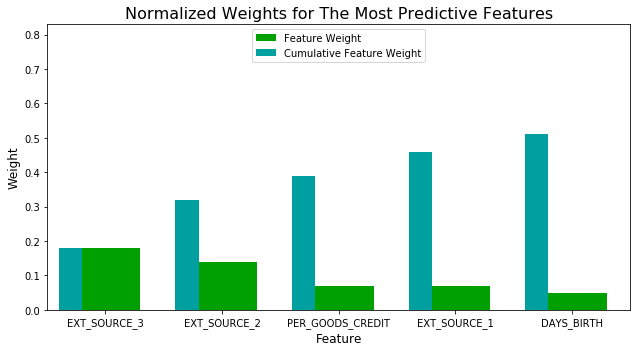

array(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'PER_GOODS_CREDIT', 'EXT_SOURCE_1',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'BOOL_FLAG_OWN_CAR', 'DAYS_ID_PUBLISH',
       'REGION_RATING_CLIENT_W_CITY', 'BOOL_FLAG_WORK_PHONE',
       'FLAG_DOCUMENT_6', 'ORGANIZATION_TYPE_Industry: type 9',
       'ORGANIZATION_TYPE_Construction', 'OCCUPATION_TYPE_Drivers',
       'OCCUPATION_TYPE_Core staff', 'NAME_INCOME_TYPE_State servant',
       'AMT_CREDIT', 'NAME_FAMILY_STATUS_Married',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Higher education', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_3', 'CODE_GENDER_M', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_13', 'ORGANIZATION_TYPE_Transport: type 3',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'ORGANIZATION_TYPE_Self-employed',
       'PER_ANNUITY_INCOME', 'TOTALAREA_MODE', 'REG_CITY

In [163]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
vs.feature_plot(importances, df_new_features, target_train)

display(df_new_features.columns.values[indices[:40]])

#### Prepare Kaggle Submission

In [167]:
# Add our new features to the full feature set
df_test_full = application_test
df_test_full = df_test_full.drop('SK_ID_CURR', axis=1)

# We need these values to be positive when calculating percentages.... 
df_temp = pd.DataFrame()
df_temp['AMT_CREDIT_OFFSET'] = df_test_full['AMT_CREDIT'] + np.min(df_test_full['AMT_CREDIT'])
df_temp['AMT_INCOME_TOTAL_OFFSET'] = df_test_full['AMT_INCOME_TOTAL'] + np.min(df_test_full['AMT_INCOME_TOTAL'])
df_temp['AMT_GOODS_PRICE_OFFSET'] = df_test_full['AMT_GOODS_PRICE'] + np.min(df_test_full['AMT_GOODS_PRICE'])
df_temp['AMT_ANNUITY_OFFSET'] = df_test_full['AMT_ANNUITY'] + np.min(df_test_full['AMT_ANNUITY'])

# Loan amount as percentage of total income
df_test_full['PER_CREDIT_INCOME'] = df_temp['AMT_CREDIT_OFFSET'] / df_temp['AMT_INCOME_TOTAL_OFFSET']

# Cost of Goods as a percentage of the loan (I suspect this will be 1 all the time)
df_test_full['PER_GOODS_CREDIT'] = df_temp['AMT_GOODS_PRICE_OFFSET'] / df_temp['AMT_CREDIT_OFFSET']

# Loan payment as a percentage of total income
df_test_full['PER_ANNUITY_INCOME'] = df_temp['AMT_ANNUITY_OFFSET'] / df_temp['AMT_INCOME_TOTAL_OFFSET']

In [168]:
# I wonder if n_estimators=1000 is actually leading us to badly overfit... 
clf = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1, n_estimators=1000, random_state=42)
clf.fit(df_new_features, target_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=1000, random_state=42)

In [169]:
predictions = clf.predict(df_test_full)

In [170]:
final_score = cross_val_score(clf, df_new_features, target_train, scoring='roc_auc', n_jobs=-1)
print("Score: {0}, Number of Predictions: {1}".format(np.mean(final_score), sum(predictions)))

Score: 0.7500941518859942, Number of Predictions: 618


In [171]:
d = {'SK_ID_CURR': application_test['SK_ID_CURR'], 'TARGET': predictions}
sub = pd.DataFrame(data=d)

print("Number of records flagged {0}".format(np.sum(sub['TARGET'])))

sub.to_csv('data/tmp/submission_bureau_full_with_new_features.csv', index=False)

Number of records flagged 618


### Kaggle Score: 
0.516

### Export

In [174]:
df_new_features['SK_ID_CURR'] = application_train['SK_ID_CURR']
df_new_features['TARGET'] = target_train
df_test_full['SK_ID_CURR'] = application_test['SK_ID_CURR']

df_new_features.to_csv('data/tmp/application_train_full_new_features.csv')
df_test_full.to_csv('data/tmp/application_test_full_new_features.csv')